In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

In [34]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [35]:
# Load dataset
raw = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
    index_col='date',
)

raw.tail(5)

,store_nbr,family,sales
date,,,
2017-08-15,9,POULTRY,438.132996
2017-08-15,9,PREPARED FOODS,154.552994
2017-08-15,9,PRODUCE,2419.729004
2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000
2017-08-15,9,SEAFOOD,16.000000


In [36]:
# Dropping store and item columns.
sales = raw[['sales']]

In [37]:
# Converting date to Month period ans sum the number of itesm in each month.
sales = sales.resample('M').sum()

In [38]:
# Dataset
sales.head()

,sales
date,
2013-01-31,10327625.0
2013-02-28,9658960.0
2013-03-31,11428497.0
2013-04-30,10993465.0
2013-05-31,11597704.0


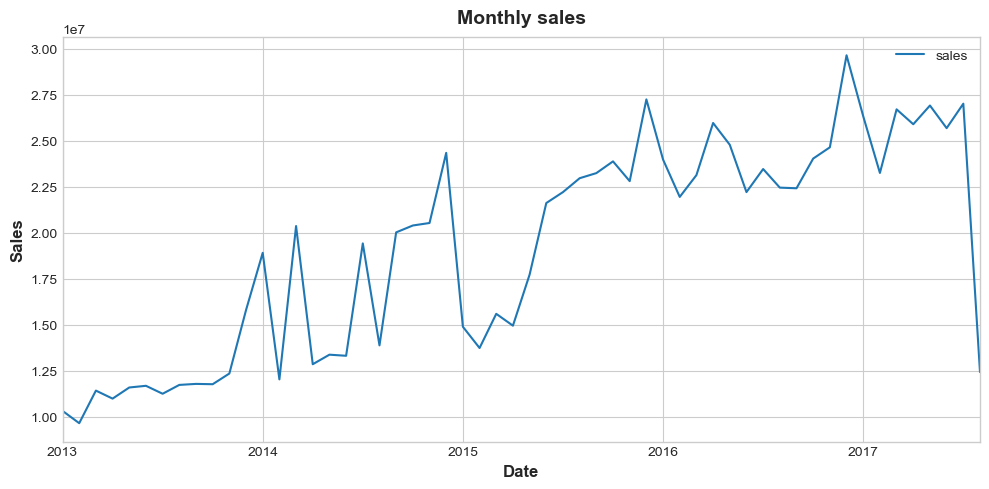

In [39]:
# Plotting the sales
sales.plot(figsize=(10,5))
plt.ylabel('Sales')
plt.xlabel('Date')
plt.title('Monthly sales');

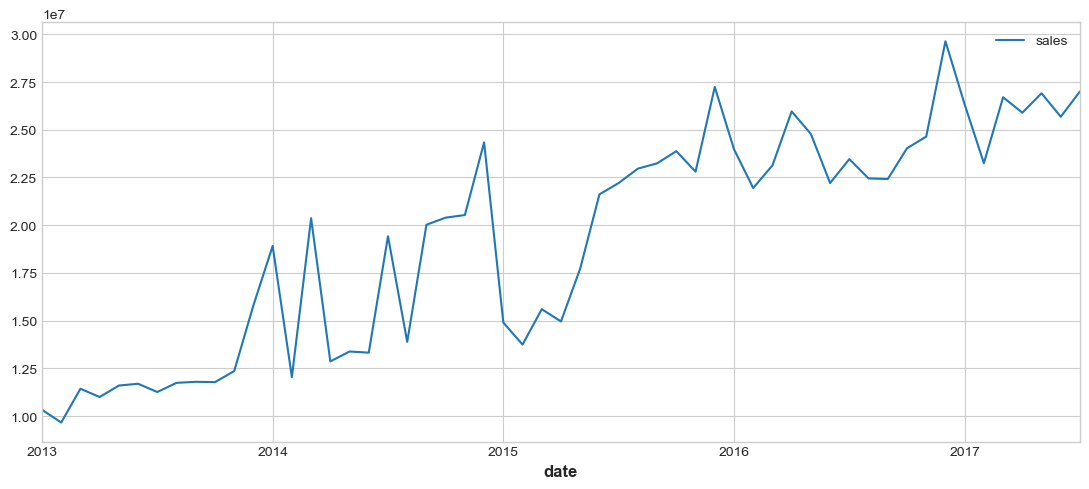

In [40]:
# Drop last period and plot sales again
data = sales.drop(sales.tail(1).index)
data.plot();

In [41]:
y = data.copy() 

dp = DeterministicProcess(
    index=y.index,
    constant=True,               
    order=1,                                     
    drop=True,                   
)

X = dp.in_sample()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7, shuffle=False)

In [43]:
model = LinearRegression(fit_intercept=False)
results = model.fit(X_train, y_train)

# Make predictions
y_fit = pd.Series(results.predict(X_train).reshape(-1), index=y_train.index)
y_pred = pd.Series(results.predict(X_test).reshape(-1), index=y_test.index)

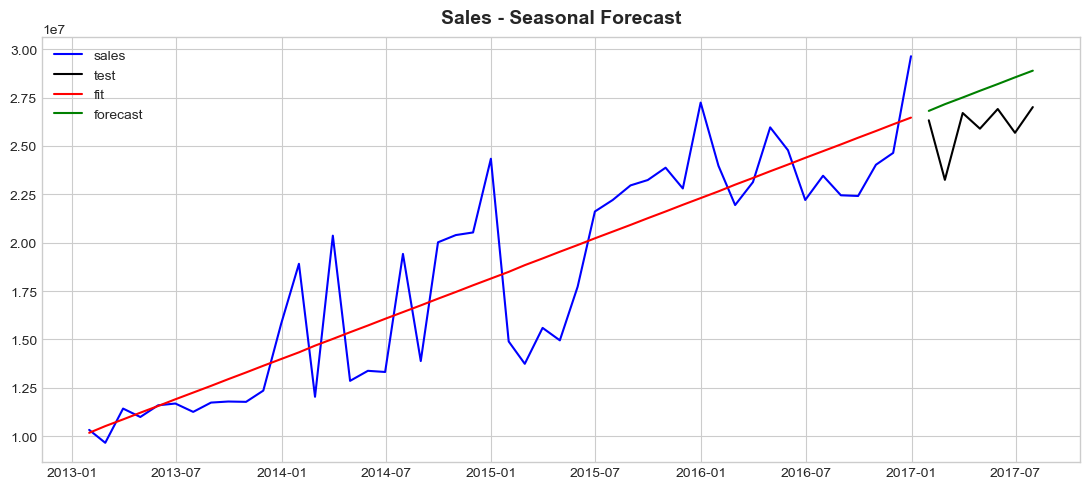

In [44]:
fig = plt.figure()
plt.plot(y_train.index, y_train, color='blue', label='sales')
plt.plot(y_test.index, y_test, color='black', label = 'test')
plt.plot(y_fit.index, y_fit, color='red', label = 'fit')
plt.plot(y_pred.index, y_pred, color='green', label='forecast')
plt.title('Sales - Seasonal Forecast')
plt.legend()
plt.show();

# fig, axs = plt.subplots(sharex=True)
# axs = y_train.plot(color='blue', subplots=True, ax=axs)
# axs = y_test.plot(color='black', subplots=True, ax=axs)
# axs = y_fit.plot(color='red', subplots=True, ax=axs)
# axs = y_pred.plot(color='green', subplots=True, ax=axs)
# for ax in axs: ax.legend([])
# plt.suptitle("Trends")
# plt.show()

In [45]:
# Adding month to train data
X['month'] = X.index.month
X = X[['month']]
X.head()

,month
date,
2013-01-31,1
2013-02-28,2
2013-03-31,3
2013-04-30,4
2013-05-31,5


In [46]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7, shuffle=False)

In [47]:
# Create residuals (the collection of detrended series) from the training set
y_resid = y_train['sales'] - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = pd.Series(xgb.predict(X_train), index=X_train.index) + y_fit
y_pred_boosted = pd.Series(xgb.predict(X_test), index=X_test.index) + y_pred

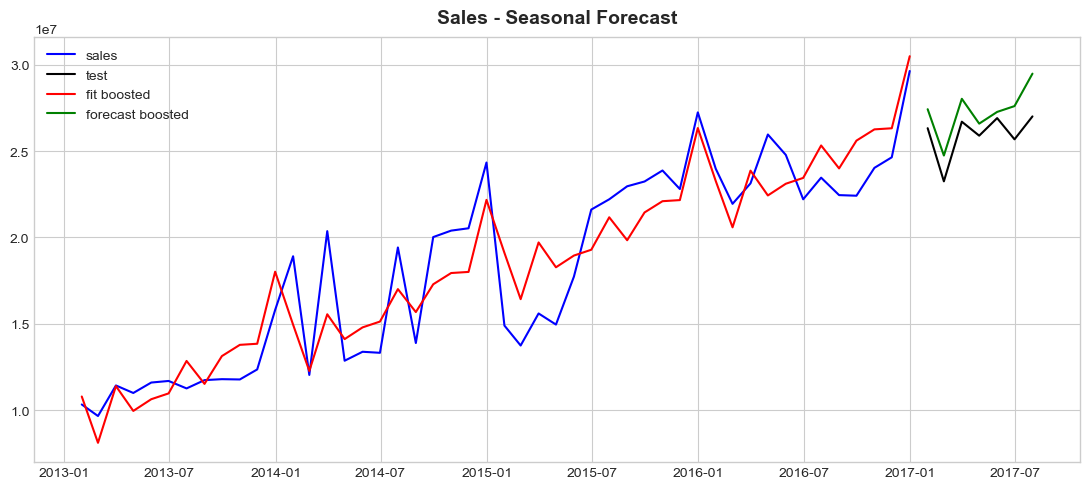

In [48]:
fig = plt.figure()
plt.plot(y_train.index, y_train, color='blue', label='sales')
plt.plot(y_test.index, y_test, color='black', label = 'test')
plt.plot(y_fit_boosted.index, y_fit_boosted, color='red', label = 'fit boosted')
plt.plot(y_pred_boosted.index, y_pred_boosted, label='forecast boosted', color='green')
plt.title('Sales - Seasonal Forecast')
plt.legend()
plt.show();

In [49]:
mse = MSE(y_test, y_pred_boosted) ** 0.5
mse

1495455.9573350751